# Actividad 4:
# Aplicación de técnicas de validación cruzada

## Objetivo
Aplicar y comparar diferentes técnicas de validación cruzada y métricas de evaluación sobre un modelo predictivo, utilizando datos reales. El estudiante deberá interpretar y justificar los resultados obtenidos en base a las métricas de rendimiento como precisión, recall, F1-Score, matriz de confusión, y curvas ROC y Precision-Recall.

**Datasets utilizados:**  
`Adult Income`

---

### Estructura del Notebook:
1. Metodología.
2. Configuración del entorno.
3. Definicion de funciones.
4. Uso de funciones y resultados.
5. Análisis de los resultados y reflexiones finales.

---

## 1. Metodología

### Flujo de trabajo

1. **Carga y preprocesamiento de datos:**
  - Se carga el dataset **Adult Income** y se hace una limpieza de datos, utilizando un 5% del total de datos como umbral para borrar o imputar los datos faltantes o que presenten problemas.

2. **Evaluación y análisis:**
  - Técnicas utilizados:
    - K-fold.
    - Stratified K-Fold
    - Leave-One-Out (LOO)

  - Métricas empleadas:
    - Precision.
    - Recall.
    - F1-Score.
    - Curvas ROC y Precision-Recall.
    - Matrices de confusión

3. **Visualización de resultados:**
  - Tabla resumen con métricas evaluadas para cada técnica, incluyendo las métricas finales con el set de prueba.
  - Gráficos de curvas ROC y curvas Precision-Recall.
  - Matrices de confusión de cada técnica, incluyendo la prueba con el test de prueba final.

---

# 2. Configuración del entorno

--- 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            confusion_matrix, ConfusionMatrixDisplay, 
                            roc_curve, auc, precision_recall_curve)

# 3. Definición de funciones

> **Nota:** Para mejor comprensión de las funciones y su utilidad, esta sección se divide en bloques, en donde cada uno responde a una parte diferente de la metodología de trabajo. 

---

**Bloque 1:** Carga y preprocesamiento de datos y entrenamiento de modelos.

- **`carga_y_preprocesamiento()`** 
Carga y prepara el dataset Adult Income, manejando valores faltantes, codificando y escalando variables, y dividiendo en train/test.

In [2]:
def carga_y_preprocesamiento():
    """
    Carga y preprocesa el dataset 'Adult Income' de OpenML para clasificación binaria.

    Pasos realizados:
    - Carga el dataset 'adult' versión 2.
    - Reemplaza valores '?' por NaN para el manejo de datos faltantes.
    - Analiza y reporta porcentaje de valores faltantes por columna.
    - Elimina columnas con más del 5% de datos faltantes.
    - Imputa valores faltantes en columnas numéricas con la mediana.
    - Imputa valores faltantes en columnas categóricas con la moda.
    - Codifica la variable objetivo 'class' a binaria: 1 si ingreso >50K, 0 en caso contrario.
    - Divide el dataset en conjuntos de entrenamiento (70%) y prueba (30%), manteniendo la proporción de clases (stratify).
    - Aplica preprocesamiento con pipelines:
        * Imputación y escalado (StandardScaler) para variables numéricas.
        * Codificación One-Hot para variables categóricas.
    - Retorna los datos preprocesados para entrenamiento y prueba.

    Returns:
        X_train_prep (np.ndarray): Matriz preprocesada de características para entrenamiento.
        X_test_prep (np.ndarray): Matriz preprocesada de características para prueba.
        y_train (pd.Series): Vector objetivo binario para entrenamiento.
        y_test (pd.Series): Vector objetivo binario para prueba.

    """
    # Cargar dataset
    adult = fetch_openml("adult", version=2, as_frame=True)
    df = adult.frame
    
    print("Distribución de clases original:")
    print(df['class'].value_counts(normalize=True))
    
    # Manejar valores faltantes
    df.replace('?', np.nan, inplace=True)
    
    # Analizar valores faltantes
    missing_percent = df.isna().mean().sort_values(ascending=False)
    print("\nPorcentaje de valores faltantes por columna:")
    print(missing_percent[missing_percent > 0])
    
    # Eliminar columnas con >10% de valores faltantes
    threshold = 0.1
    cols_to_drop = missing_percent[missing_percent > threshold].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # Variable objetivo binaria
    y = (df['class'] == '>50K').astype(int)
    X = df.drop('class', axis=1)
    
    # Dividir en train/test (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Preprocesamiento
    num_cols = X_train.select_dtypes(include=['int', 'float']).columns
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
    
    # Crear pipeline para variables numéricas
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Codificación para variables categóricas
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer combinando ambos
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    print(f"\nDimensiones después de preprocesamiento:")
    print(f"Train: {X_train_prep.shape}, Test: {X_test_prep.shape}")
    
    return X_train_prep, X_test_prep, y_train, y_test

**Bloque 2:** Evaluación de técnicas de Cross Validation.

- **`evaluar_tecnica()`** 
Evalúa un modelo de clasificación usando un método de validación cruzada, retornando métricas y predicciones.

In [3]:
def evaluar_tecnica(model, X, y, cv_method, method_name):
    """
    Evalúa un modelo de clasificación usando un método de validación cruzada especificado.

    El procedimiento incluye:
    - Dividir los datos según el método de validación cruzada (cv_method).
    - Entrenar el modelo en cada fold.
    - Predecir probabilidades y etiquetas para el conjunto de validación.
    - Agregar las predicciones y probabilidades en los índices correspondientes.
    - Calcular métricas de evaluación: precisión, recall y F1-score.

    Args:
        model: Estimador de clasificación con método fit() y predict_proba().
        X (array-like o DataFrame): Matriz de características.
        y (array-like o Serie): Vector objetivo binario.
        cv_method: Objeto de validación cruzada que implementa split(X, y).
        method_name (str): Nombre descriptivo de la técnica evaluada (ej. 'K-Fold').

    Returns:
        dict: Diccionario con las siguientes claves:
            - 'method' (str): nombre de la técnica.
            - 'precision' (float): precisión global del modelo.
            - 'recall' (float): recall global del modelo.
            - 'f1' (float): F1-score global del modelo.
            - 'y_probs' (np.ndarray): probabilidades predichas para la clase positiva en todo el conjunto.
            - 'y_preds' (np.ndarray): predicciones binarias para todo el conjunto.
            - 'y_true' (np.ndarray): etiquetas verdaderas del conjunto.
    """
    # Convertir a arrays numpy
    X = X.values if hasattr(X, 'values') else X
    y = y.values if hasattr(y, 'values') else y
    
    # Inicializar arrays para resultados
    y_probs = np.zeros(len(y))
    y_preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    # Iterar sobre los folds
    for i, (train_idx, val_idx) in enumerate(cv_method.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Entrenar modelo
        model.fit(X_train, y_train)
        
        # Predecir probabilidades
        fold_probs = model.predict_proba(X_val)[:, 1]
        fold_preds = (fold_probs >= 0.5).astype(int)
        
        # Almacenar resultados
        y_probs[val_idx] = fold_probs
        y_preds[val_idx] = fold_preds
        y_true[val_idx] = y_val
    
    # Calcular métricas
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    return {
        'method': method_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_probs': y_probs,
        'y_preds': y_preds,
        'y_true': y_true  # Almacenar las etiquetas reales
    }

**Bloque 3:** Visualización de resultados.

- **`graficar_curvas_comparativas()`** 
Grafica curvas ROC y Precision-Recall para comparar múltiples modelos.

- **`graficar_matrices_confusion()`** 
Muestra las matrices de confusión de varios modelos en subgráficos.

- **`crear_tabla_metricas()`** 
Imprime una tabla comparativa con precisión, recall y F1-score para cada modelo.

In [4]:
def graficar_curvas_comparativas(results):
    """
    Grafica comparativamente las curvas ROC y Precision-Recall para varios modelos.

    Cada modelo se representa en dos subgráficos:
    - Curva ROC (Tasa de Falsos Positivos vs Tasa de Verdaderos Positivos) con su AUC.
    - Curva Precision-Recall mostrando la relación entre precisión y recall.

    Args:
        results (list of dict): Lista de diccionarios con resultados de modelos, 
            cada uno debe contener:
            - 'method': nombre del método/modelo (str).
            - 'y_true': etiquetas verdaderas (array-like).
            - 'y_probs': probabilidades predichas para la clase positiva (array-like).
    """
    """Grafica ROC y Precision-Recall en una misma figura para comparar modelos."""
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for res in results:
        # Curva ROC
        fpr, tpr, _ = roc_curve(res['y_true'], res['y_probs'])
        roc_auc = auc(fpr, tpr)
        axs[0].plot(fpr, tpr, lw=2, label=f"{res['method']} (AUC = {roc_auc:.2f})")

        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(res['y_true'], res['y_probs'])
        axs[1].plot(recall, precision, lw=2, label=f"{res['method']}")

    # Configurar subplot ROC
    axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Curva ROC')
    axs[0].legend(loc="lower right")

    # Configurar subplot Precision-Recall
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Curva Precision-Recall')
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

def graficar_matrices_confusion(results):
    """
    Muestra las matrices de confusión para varios modelos en una fila de gráficos.

    Para cada conjunto de resultados, calcula y dibuja la matriz de confusión correspondiente,
    con título indicando el método.

    Args:
        results (list of dict): Lista de diccionarios con resultados de modelos, 
            cada uno debe contener:
            - 'method': nombre del método/modelo (str).
            - 'y_true': etiquetas verdaderas (array-like).
            - 'y_preds': etiquetas predichas binarias (array-like).
    """
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    
    if n == 1:
        axes = [axes]
    
    for i, res in enumerate(results):
        cm = confusion_matrix(res['y_true'], res['y_preds'])
        f1 = f1_score(res['y_true'], res['y_preds'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], colorbar=False)
        axes[i].set_title(f"{res['method']}\nF1: {f1:.2f}")
    
    plt.tight_layout()
    plt.show()

def crear_tabla_metricas(results):
    """
    Imprime en consola una tabla comparativa con las métricas precisión, recall y F1-score de varios modelos.

    La tabla presenta los nombres de los métodos y sus métricas con cuatro decimales.

    Args:
        results (list of dict): Lista de diccionarios con resultados de modelos, 
            cada uno debe contener:
            - 'method': nombre del método/modelo (str).
            - 'precision': precisión (float).
            - 'recall': recall (float).
            - 'f1': F1-score (float).
    """
    print("\nTabla Comparativa de Métricas:")
    print("=" * 60)
    print(f"{'Método':<25} {'Precisión':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)
    
    for res in results:
        print(f"{res['method']:<25} {res['precision']:.4f}{'':<6} {res['recall']:.4f}{'':<6} {res['f1']:.4f}")
    print("=" * 60)

**Bloque 4:** Función de ejecución del código.

- **`main()`** 
Ejecuta todo el flujo: carga datos, entrena y evalúa modelos con distintas validaciones cruzadas, y muestra los resultados.

In [5]:
def main():
    """
    Ejecuta el flujo principal de carga, preprocesamiento, entrenamiento, evaluación y visualización
    de un modelo de clasificación usando diferentes métodos de validación cruzada.

    Pasos:
    1. Carga y preprocesa el dataset Adult Income.
    2. Inicializa un clasificador Random Forest con parámetros específicos.
    3. Evalúa el modelo usando:
       - K-Fold Cross Validation
       - Stratified K-Fold Cross Validation
       - Leave-One-Out (LOO) sobre una muestra reducida (máximo 500)
    4. Entrena el modelo final con todo el set de entrenamiento y evalúa en el conjunto de prueba.
    5. Agrega los resultados del conjunto de prueba a la comparación.
    6. Visualiza y compara los resultados mediante tablas, curvas ROC/Precision-Recall y matrices de confusión.

    No recibe argumentos ni retorna valores.

    """
    # 1. Cargar y preprocesar datos
    X_train, X_test, y_train, y_test = carga_y_preprocesamiento()
    
    # 2. Inicializar modelo
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # 3. Evaluar con diferentes métodos de CV
    results = []
    
    # K-Fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results.append(evaluar_tecnica(model, X_train, y_train, kfold, "K-Fold"))
    
    # Stratified K-Fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results.append(evaluar_tecnica(model, X_train, y_train, skfold, "Stratified K-Fold"))
    
    # Leave-One-Out (con muestra reducida)
    sample_size = min(500, len(y_train))
    loo_sample = np.random.choice(len(y_train), sample_size, replace=False)
    loo = LeaveOneOut()
    results.append(evaluar_tecnica(
        model, 
        X_train[loo_sample], 
        y_train.iloc[loo_sample] if hasattr(y_train, 'iloc') else y_train[loo_sample], 
        loo, 
        "LOO (muestra)"
    ))

    # 4. Evaluación final en test set
    model.fit(X_train, y_train)
    test_probs = model.predict_proba(X_test)[:, 1]
    test_preds = (test_probs >= 0.5).astype(int)
    
    test_result = {
        'method': 'Conjunto de prueba',
        'precision': precision_score(y_test, test_preds),
        'recall': recall_score(y_test, test_preds),
        'f1': f1_score(y_test, test_preds),
        'y_probs': test_probs,
        'y_preds': test_preds,
        'y_true': y_test.values if hasattr(y_test, 'values') else y_test
    }
    
    results.append(test_result)  # <--- agregar a la lista
    
    # 5. Visualizar resultados
    crear_tabla_metricas(results)
    graficar_curvas_comparativas(results)
    graficar_matrices_confusion(results)

# 4. Visualización de resultados

Se muestran los resultados obtenidos a partir de la ejecución de la funcion **main()**.

---

Distribución de clases original:
class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

Porcentaje de valores faltantes por columna:
occupation        0.057512
workclass         0.057307
native-country    0.017546
dtype: float64

Dimensiones después de preprocesamiento:
Train: (34189, 105), Test: (14653, 105)

Tabla Comparativa de Métricas:
Método                    Precisión  Recall     F1-Score  
------------------------------------------------------------
K-Fold                    0.7247       0.6150       0.6653
Stratified K-Fold         0.7194       0.6175       0.6646
LOO (muestra)             0.7412       0.5780       0.6495
Conjunto de prueba        0.7352       0.6215       0.6736


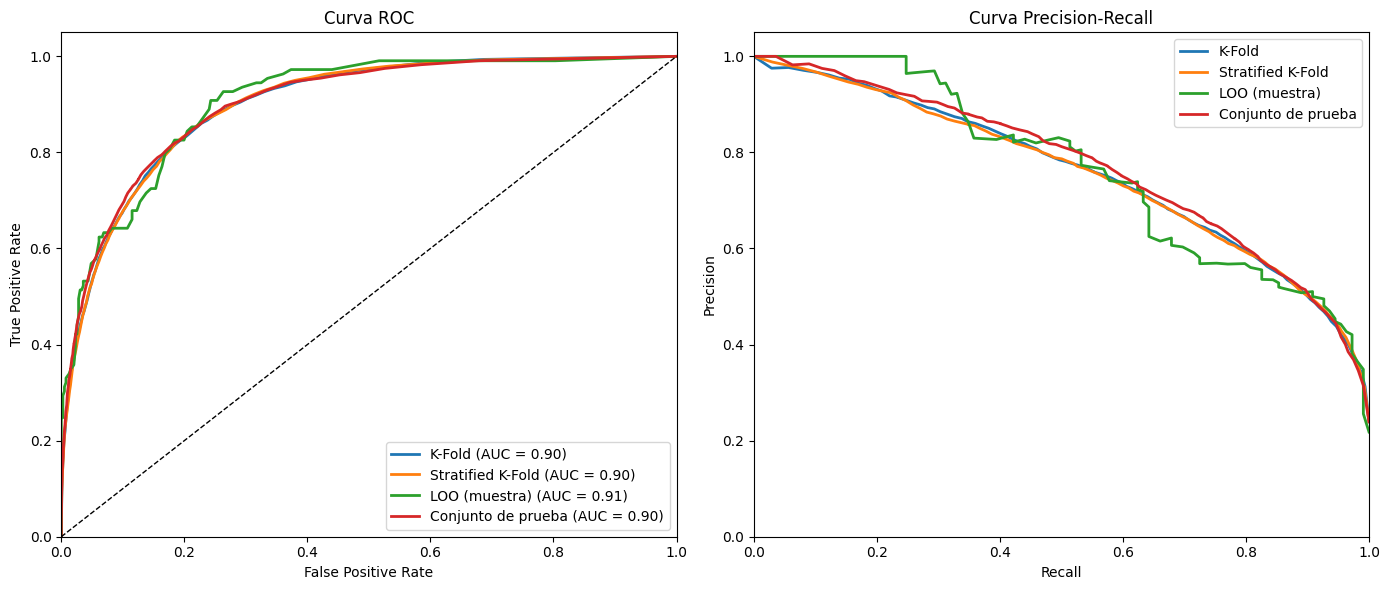

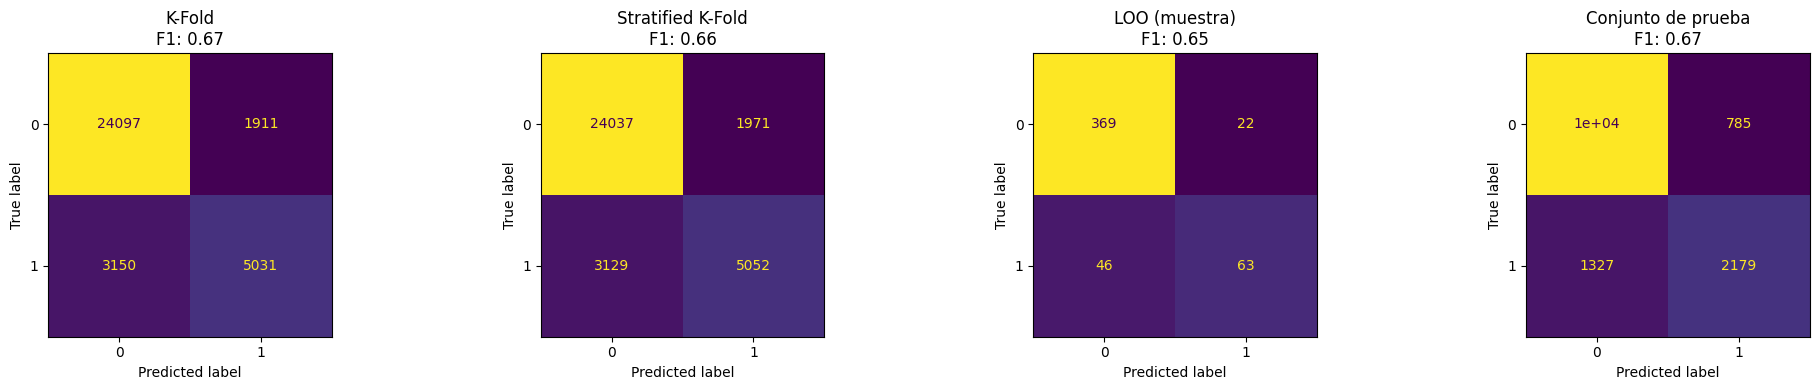

In [6]:
if __name__ == "__main__":
    main()

# Análisis de resultados

> **Justificación del uso de LOO con submuestra:** Leave-One-Out (LOO) es un método de validación cruzada extremadamente costoso en términos computacionales, ya que entrena un modelo por cada muestra del dataset. En este trabajo, se utilizó el dataset Adult Income, que contiene aproximadamente 50.000 registros. Aplicar LOO sobre el conjunto completo habría requerido un tiempo de ejecución prohibitivo.
Por esta razón, se optó por aplicar LOO sobre una submuestra aleatoria reducida. Sin embargo, esto implica que los resultados obtenidos con LOO podrían no ser plenamente representativos del comportamiento del modelo sobre el dataset completo, por ejemplo, podria mostrar métricas superiores a los demas, o inferiores, dependiendo de que sub muestra haya tomado.

> **Justificación por no aplicar Time Series Cross Validation:** El método de validación cruzada temporal (Time Series CV) se utiliza exclusivamente en datasets donde el orden temporal de las observaciones es relevante, como series de ventas, precios o comportamiento a lo largo del tiempo.
En este caso, el dataset Adult Income no contiene una variable de tiempo explícita ni un orden secuencial que condicione la predicción. Las muestras son independientes entre sí, por lo tanto, aplicar Time Series CV no tendría sentido y podría inducir errores metodológicos.

### K-Fold

- Divide el dataset aleatoriamente en k partes sin considerar la distribución de clases.
- Sus métricas están bastante alineadas con el conjunto de prueba.

> Desventaja: En datasets desbalanceados (como Adult Income, donde solo ~24% de las personas ganan >50K), puede generar divisiones con sesgos de clase, afectando la estabilidad del modelo en algunos folds.

### Stratified K-Fold

- Funciona como K-Fold, pero asegura que cada fold preserve la distribución de clases del conjunto original.
- Ideal para clasificación binaria desbalanceada, ya que reduce la varianza entre folds y genera resultados más representativos.
- Las métricas obtenidas son muy similares a las de K-Fold y del conjunto de prueba, lo que refleja buena estabilidad.

> Recomendación: En problemas de clasificación con clases desbalanceadas, Stratified K-Fold es preferible por su robustez y precisión en la estimación.

### Leave-One-Out (LOO) con muestra mas pequeña

- Entrena un modelo dejando una muestra fuera en cada iteración, lo que genera una gran cantidad de modelos distintos.
- Se utilizó una muestra aleatoria reducida por motivos computacionales, lo que puede introducir varianza en los resultados dependiendo del subconjunto seleccionado.
- Aunque en algunas ejecuciones LOO puede mostrar métricas competitivas (incluso superiores), se ha observado que sus curvas ROC y Precision-Recall suelen ser más inestables y "dientudas", lo que refleja:
    - Alta sensibilidad a casos individuales.
    - Posible sobreajuste en la submuestra.
    - Predicciones menos consistentes al variar los umbrales.

> Desventajas de LOO en este contexto:
>   - Elevado costo computacional.
>   - Alta varianza entre ejecuciones.
>   - Curvas de rendimiento irregulares.
>   - Evaluación poco confiable en submuestras pequeñas.

### Conjunto de prueba

- Representa la evaluación final y real del modelo entrenado con todo el conjunto de entrenamiento.
- En este caso, obtuvo uno de los mejores F1-scores, lo que valida que el modelo generaliza adecuadamente.
- Su similitud con las métricas de K-Fold y Stratified K-Fold indica que estos métodos de validación cruzada proporcionan estimaciones confiables.

---

## Conclusión

- Stratified K-Fold se consolida como la técnica más robusta y adecuada para este problema:
    - Clasificación binaria.
    - Dataset desbalanceado.
    - Métricas estables y representativas.
    - Curvas ROC y PR suaves y consistentes.
- K-Fold es una alternativa razonable, aunque potencialmente menos precisa en datasets desbalanceados.
- LOO, aunque teóricamente atractivo por su bajo sesgo, no es recomendable aquí debido a su alto costo, sensibilidad al ruido y a su evaluación menos representativa (especialmente en submuestras).
- La evaluación sobre el conjunto de prueba respalda la elección de los métodos de validación cruzada aplicados, en particular, Stratified K-Fold, al demostrar que las métricas estimadas durante la validación son coherentes con la generalización real del modelo.